Dataset: https://github.com/MedMNIST/MedMNIST/tree/main

## Import

In [ ]:
!pip install medmnist
!pip install optuna

In [ ]:
from tqdm.autonotebook import tqdm, trange
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F
import optuna
from optuna.trial import TrialState
import matplotlib.pyplot as plt

import medmnist
from medmnist import INFO, Evaluator
import gc
import pandas as pd

## Data

In [ ]:
data_flag = 'pathmnist'

BATCH_SIZE = 127
device = 'cuda'

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [ ]:
info

{'python_class': 'PathMNIST',
 'description': 'The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test set.',
 'url': 'https://zenodo.org/records/10519652/files/pathmnist.npz?download=1',
 'MD5': 'a8b06965200029087d5bd730944a56c1',
 'url_64': 'https://zenodo.org/records/10519652/files/pathmnist_64.npz?download=1',
 'MD5_64': '55aa9c1e0525abe5a6b9d8343a507616',
 'url_128': 'https://zenodo.org/records/10519652/files/pathmnist_128.npz?download=1',
 'MD5

In [ ]:
# preprocessing
data_transform = transforms.Compose([
    # transforms.Resize(size=32),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])
data_transform_size = transforms.Compose([
    transforms.Resize(size=32),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])
data_transform_collor = transforms.Compose([
    transforms.ColorJitter(brightness=(0.7,1.3),contrast=(0.7,1.3),hue=(-0.1,0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])
# load the data
train_dataset = DataClass(split='train', transform=data_transform_collor, download=True)
val_dataset = DataClass(split='val', transform=data_transform, download=True)
test_dataset = DataClass(split='test', transform=data_transform, download=True)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE)

100%|██████████| 205615438/205615438 [00:15<00:00, 12872240.01it/s]


Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz


(-0.5, 27.5, 27.5, -0.5)

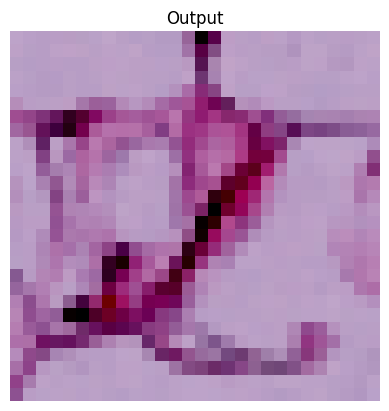

In [ ]:
a = train_dataset[75][0]
b = [[[a[0][i][j],a[1][i][j],a[2][i][j]] for j in range(28)] for i in range(28)]
plt.imshow(b)
plt.title('Output')
plt.axis('off')

In [ ]:
r = next(iter(test_loader))[0]
print(r.min())
print(r.max())
print(r.mean())

tensor(0.)
tensor(1.)
tensor(0.6572)


/usr/local/lib/python3.10/dist-packages/medmnist/utils.py:31: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


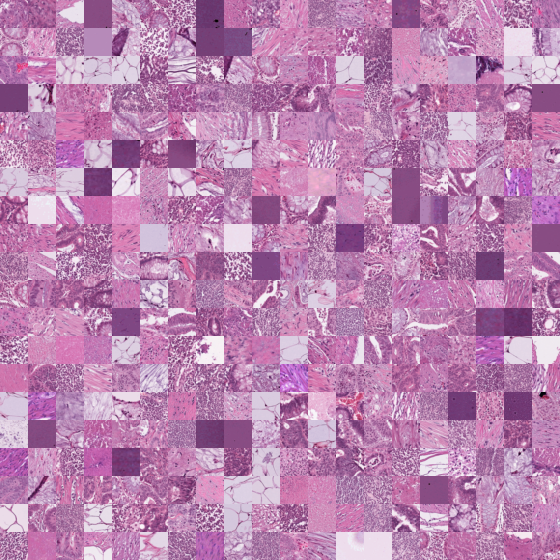

In [ ]:
train_dataset.montage(length=20)

## Augmentation Test on ResNet-18

In [ ]:
def train_val(model, optimizer, criterion, scheduler, epochs, train_loader, val_loader, train_size):
    pbar = trange(epochs, desc="Epoch:")
    for epoch in pbar:
        train_correct = 0
        y_val = torch.tensor([])

        model.train()
        for inputs, targets in tqdm(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs.to(device))

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32).to(device)
            else:
                targets = targets.squeeze().long().to(device)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            preds = torch.argmax(outputs, 1)
            train_correct +=  torch.sum(preds == targets).item()
        train_acc = train_correct / train_size
        scheduler.step()

        model.eval()
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs.to(device))

                if task == 'multi-label, binary-class':
                    targets = targets.to(torch.float32)
                    outputs = outputs.softmax(dim=-1).cpu()
                else:
                    targets = targets.squeeze().long()
                    outputs = outputs.softmax(dim=-1).cpu()
                    targets = targets.float().resize_(len(targets), 1)
                y_val = torch.cat((y_val, outputs), 0)
            y_val = y_val.detach().numpy()

            evaluator = Evaluator(data_flag, 'val')
            metrics = evaluator.evaluate(y_val)
            print('Epoch '+ str(epoch + 1) + ') train acc: ' + str(train_acc) + ', %s auc: %.3f, val acc: %.3f' % ('val', *metrics))

In [ ]:
def test(model, criterion, test_loader):
    model.eval()
    y_test = torch.tensor([])
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs.to(device))

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1).cpu()
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1).cpu()
                targets = targets.float().resize_(len(targets), 1)
            y_test = torch.cat((y_test, outputs), 0)
        y_test = y_test.detach().numpy()

        evaluator = Evaluator(data_flag, 'test')
        metrics = evaluator.evaluate(y_test)

        print('%s auc: %.3f, test acc: %.3f' % ('test', *metrics))

In [ ]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, n_classes)
model.to(device)
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[4, 7], gamma=0.1)
epochs = 10
train_val(model=model, optimizer=optimizer, criterion=criterion, scheduler=scheduler, epochs=epochs,
          train_loader=train_loader, val_loader=val_loader, train_size=len(train_dataset))
test(model=model, criterion=criterion, test_loader=test_loader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 1) train acc: 0.8053135694919774, val auc: 0.988, val acc: 0.857


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 2) train acc: 0.8690386239388417, val auc: 0.992, val acc: 0.893


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 3) train acc: 0.8895839815102894, val auc: 0.993, val acc: 0.904


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 4) train acc: 0.9031290279567981, val auc: 0.993, val acc: 0.900


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 5) train acc: 0.9422863238366149, val auc: 0.996, val acc: 0.926


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 6) train acc: 0.9523312147206543, val auc: 0.996, val acc: 0.927


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 7) train acc: 0.9598204364638429, val auc: 0.996, val acc: 0.927


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 8) train acc: 0.9667318547491, val auc: 0.996, val acc: 0.927


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 9) train acc: 0.9679096848748834, val auc: 0.996, val acc: 0.927


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 10) train acc: 0.9687875016667408, val auc: 0.996, val acc: 0.927
test auc: 0.990, test acc: 0.890


In [ ]:
# without augmentations, 10 epochs, milestones=[4, 7]
# val auc: 0.999, val acc: 0.964
# test auc: 0.981, test acc: 0.860

# val auc: 0.999, val acc: 0.963
# test auc: 0.982, test acc: 0.854

# val auc: 0.999, val acc: 0.965
# test auc: 0.982, test acc: 0.855

# Average
# val auc: 0.999, val acc: 0.64
# test auc: 0.982, test acc: 0.856

In [ ]:
# with resizing, 10 epochs, milestones=[4, 7]
# val auc: 0.982, val acc: 0.809
# test auc: 0.957, test acc: 0.736

# val auc: 0.973, val acc: 0.767
# test auc: 0.953, test acc: 0.721

# val auc: 0.971, val acc: 0.754
# test auc: 0.940, test acc: 0.688

# Average
# val auc: 0.975, val acc: 0.777
# test auc: 0.950, test acc: 0.715

In [ ]:
# with CollorJitter, 10 epochs, milestones=[4, 7]
# val auc: 0.996, val acc: 0.927
# test auc: 0.990, test acc: 0.890

# val auc: 0.996, val acc: 0.925
# test auc: 0.989, test acc: 0.885

# val auc: 0.996, val acc: 0.930
# test auc: 0.989, test acc: 0.882

# Average
# val auc: 0.996, val acc: 0.927
# test auc: 0.989, test acc: 0.886

## Several models


### Models

In [ ]:
# suggested
class DefaultNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(DefaultNet, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(n_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
class FirstNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(FirstNet, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(n_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv2d(32, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer6 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU())

        self.layer7 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU())

        self.fc = nn.Sequential(
            nn.Linear(256 * 3 * 3, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, n_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
class DropoutNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(DropoutNet, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(n_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.Dropout2d(),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.Dropout2d(),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.Dropout2d(),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv2d(32, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.Dropout2d(),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.Dropout2d(),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer6 = nn.Sequential(########
            nn.Conv2d(128, 128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.Dropout2d(),
            nn.ReLU())

        self.layer7 = nn.Sequential(########
            nn.Conv2d(128, 256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.Dropout2d(),
            nn.ReLU())

        self.fc = nn.Sequential(
            nn.Linear(256 * 3 * 3, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(256, n_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

### Train

#### Default model

In [ ]:
model = DefaultNet(n_channels=n_channels, n_classes=n_classes).to(device)
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[4, 7], gamma=0.1)
epochs = 10
train_val(model=model, optimizer=optimizer, criterion=criterion, scheduler=scheduler, epochs=epochs,
          train_loader=train_loader, val_loader=val_loader, train_size=len(train_dataset))
test(model=model, criterion=criterion, test_loader=test_loader)

Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 1) train acc: 0.6506733632605893, val auc: 0.970, val acc: 0.764


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 2) train acc: 0.7770567580781368, val auc: 0.980, val acc: 0.809


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 3) train acc: 0.8206698075470021, val auc: 0.988, val acc: 0.860


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 4) train acc: 0.8484265967376328, val auc: 0.990, val acc: 0.865


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 5) train acc: 0.8865282901462287, val auc: 0.993, val acc: 0.901


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 6) train acc: 0.8923174363305035, val auc: 0.993, val acc: 0.903


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 7) train acc: 0.8965620694253078, val auc: 0.993, val acc: 0.905


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 8) train acc: 0.9014067291879639, val auc: 0.993, val acc: 0.906


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 9) train acc: 0.9024623316591849, val auc: 0.994, val acc: 0.907


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 10) train acc: 0.9029401306724744, val auc: 0.993, val acc: 0.906
test auc: 0.989, test acc: 0.890


In [ ]:
model = DefaultNet(n_channels=n_channels, n_classes=n_classes).to(device)
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[4, 7], gamma=0.1)
epochs = 10
train_val(model=model, optimizer=optimizer, criterion=criterion, scheduler=scheduler, epochs=epochs,
          train_loader=train_loader, val_loader=val_loader, train_size=len(train_dataset))
test(model=model, criterion=criterion, test_loader=test_loader)

Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 1) train acc: 0.6405951375616694, val auc: 0.968, val acc: 0.728


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 2) train acc: 0.7736010489355083, val auc: 0.980, val acc: 0.810


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 3) train acc: 0.8174474421085381, val auc: 0.987, val acc: 0.857


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 4) train acc: 0.8410373794390862, val auc: 0.986, val acc: 0.823


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 5) train acc: 0.878783501488955, val auc: 0.991, val acc: 0.886


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 6) train acc: 0.8845615360682697, val auc: 0.992, val acc: 0.891


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 7) train acc: 0.8875950042224099, val auc: 0.992, val acc: 0.889


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 8) train acc: 0.893395262011645, val auc: 0.992, val acc: 0.893


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 9) train acc: 0.8938063913951731, val auc: 0.992, val acc: 0.895


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 10) train acc: 0.8944730876927863, val auc: 0.992, val acc: 0.893
test auc: 0.989, test acc: 0.886


In [ ]:
model = DefaultNet(n_channels=n_channels, n_classes=n_classes).to(device)
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[4, 7], gamma=0.1)
epochs = 10
train_val(model=model, optimizer=optimizer, criterion=criterion, scheduler=scheduler, epochs=epochs,
          train_loader=train_loader, val_loader=val_loader, train_size=len(train_dataset))
test(model=model, criterion=criterion, test_loader=test_loader)

Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 1) train acc: 0.6560291568514156, val auc: 0.960, val acc: 0.715


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 2) train acc: 0.7887350548913286, val auc: 0.979, val acc: 0.792


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 3) train acc: 0.8323369927552335, val auc: 0.987, val acc: 0.853


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 4) train acc: 0.8563936174941108, val auc: 0.990, val acc: 0.864


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 5) train acc: 0.8909395973154363, val auc: 0.993, val acc: 0.907


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 6) train acc: 0.895817591892973, val auc: 0.994, val acc: 0.909


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 7) train acc: 0.8995066447397662, val auc: 0.994, val acc: 0.908


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 8) train acc: 0.9028290146228721, val auc: 0.994, val acc: 0.912


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 9) train acc: 0.9032179207964799, val auc: 0.994, val acc: 0.913


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 10) train acc: 0.9048624383305924, val auc: 0.994, val acc: 0.914
test auc: 0.989, test acc: 0.886


In [ ]:
# DefaultNet, 10 epochs, milestones=[4, 7]
# val auc: 0.993, val acc: 0.906
# test auc: 0.989, test acc: 0.890

# val auc: 0.992, val acc: 0.893
# test auc: 0.989, test acc: 0.886

# val auc: 0.994, val acc: 0.914
# test auc: 0.989, test acc: 0.886

# Average
# val auc: 0.993, val acc: 0.904
# test auc: 0.989, test acc: 0.887

#### First model

In [ ]:
model = FirstNet(n_channels=n_channels, n_classes=n_classes).to(device)
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[4, 7], gamma=0.1)
epochs = 10
train_val(model=model, optimizer=optimizer, criterion=criterion, scheduler=scheduler, epochs=epochs,
          train_loader=train_loader, val_loader=val_loader, train_size=len(train_dataset))
test(model=model, criterion=criterion, test_loader=test_loader)

Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 1) train acc: 0.7090315125116672, val auc: 0.984, val acc: 0.840


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 2) train acc: 0.8506600293346371, val auc: 0.991, val acc: 0.872


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 3) train acc: 0.8905840259567092, val auc: 0.993, val acc: 0.885


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 4) train acc: 0.9103960176007823, val auc: 0.996, val acc: 0.922


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 5) train acc: 0.9442086314947331, val auc: 0.998, val acc: 0.947


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 6) train acc: 0.952575670029779, val auc: 0.998, val acc: 0.950


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 7) train acc: 0.9551980088003911, val auc: 0.998, val acc: 0.948


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 8) train acc: 0.9599871105382461, val auc: 0.998, val acc: 0.952


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 9) train acc: 0.9612093870838704, val auc: 0.998, val acc: 0.951


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 10) train acc: 0.9634205964709542, val auc: 0.998, val acc: 0.952
test auc: 0.993, test acc: 0.917


In [ ]:
model = FirstNet(n_channels=n_channels, n_classes=n_classes).to(device)
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[4, 7], gamma=0.1)
epochs = 10
train_val(model=model, optimizer=optimizer, criterion=criterion, scheduler=scheduler, epochs=epochs,
          train_loader=train_loader, val_loader=val_loader, train_size=len(train_dataset))
test(model=model, criterion=criterion, test_loader=test_loader)

Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 1) train acc: 0.7064313969509756, val auc: 0.979, val acc: 0.789


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 2) train acc: 0.8440819591981866, val auc: 0.992, val acc: 0.876


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 3) train acc: 0.883972621005378, val auc: 0.993, val acc: 0.898


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 4) train acc: 0.9077181208053692, val auc: 0.993, val acc: 0.895


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 5) train acc: 0.9450975598915508, val auc: 0.997, val acc: 0.945


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 6) train acc: 0.9512756122494334, val auc: 0.997, val acc: 0.944


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 7) train acc: 0.9557313658384817, val auc: 0.998, val acc: 0.947


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 8) train acc: 0.9617205209120405, val auc: 0.998, val acc: 0.948


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 9) train acc: 0.9628427930130228, val auc: 0.998, val acc: 0.947


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 10) train acc: 0.964065069558647, val auc: 0.998, val acc: 0.949
test auc: 0.992, test acc: 0.914


In [ ]:
model = FirstNet(n_channels=n_channels, n_classes=n_classes).to(device)
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[4, 7], gamma=0.1)
epochs = 10
train_val(model=model, optimizer=optimizer, criterion=criterion, scheduler=scheduler, epochs=epochs,
          train_loader=train_loader, val_loader=val_loader, train_size=len(train_dataset))
test(model=model, criterion=criterion, test_loader=test_loader)

Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 1) train acc: 0.7091204053513489, val auc: 0.980, val acc: 0.803


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 2) train acc: 0.8487043868616383, val auc: 0.991, val acc: 0.881


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 3) train acc: 0.8879172407662563, val auc: 0.993, val acc: 0.898


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 4) train acc: 0.9069847548779946, val auc: 0.996, val acc: 0.921


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 5) train acc: 0.9418751944530868, val auc: 0.998, val acc: 0.948


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 6) train acc: 0.9497422107649229, val auc: 0.998, val acc: 0.949


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 7) train acc: 0.9536090492910796, val auc: 0.998, val acc: 0.949


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 8) train acc: 0.9595093115249567, val auc: 0.998, val acc: 0.952


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 9) train acc: 0.9606093604160185, val auc: 0.998, val acc: 0.952


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 10) train acc: 0.9620316458509267, val auc: 0.998, val acc: 0.953
test auc: 0.993, test acc: 0.916


In [ ]:
# FirstNet, 10 epochs, milestones=[4, 7]
# val auc: 0.998, val acc: 0.952
# test auc: 0.993, test acc: 0.917

# val auc: 0.998, val acc: 0.949
# test auc: 0.992, test acc: 0.914

# val auc: 0.998, val acc: 0.953
# test auc: 0.993, test acc: 0.916

# Average
# val auc: 0.998, val acc: 0.951
# test auc: 0.993, test acc: 0.916

#### Dropout model

In [ ]:
model = DropoutNet(n_channels=n_channels, n_classes=n_classes).to(device)
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[4, 7], gamma=0.1)
epochs = 10
train_val(model=model, optimizer=optimizer, criterion=criterion, scheduler=scheduler, epochs=epochs,
          train_loader=train_loader, val_loader=val_loader, train_size=len(train_dataset))
test(model=model, criterion=criterion, test_loader=test_loader)

Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 1) train acc: 0.25400017778567935, val auc: 0.607, val acc: 0.106


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 2) train acc: 0.32102537890572913, val auc: 0.638, val acc: 0.106


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 3) train acc: 0.3442708564825103, val auc: 0.741, val acc: 0.192


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 4) train acc: 0.39296190941819636, val auc: 0.740, val acc: 0.202


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 5) train acc: 0.43310813813947285, val auc: 0.733, val acc: 0.173


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 6) train acc: 0.4383305924707765, val auc: 0.732, val acc: 0.202


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 7) train acc: 0.44666429619094183, val auc: 0.738, val acc: 0.208


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 8) train acc: 0.4496422063202809, val auc: 0.735, val acc: 0.197


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 9) train acc: 0.45016445175341124, val auc: 0.735, val acc: 0.203


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 10) train acc: 0.4508200364460643, val auc: 0.729, val acc: 0.160
test auc: 0.777, test acc: 0.221


In [ ]:
model = DropoutNet(n_channels=n_channels, n_classes=n_classes).to(device)
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[4, 7], gamma=0.1)
epochs = 10
train_val(model=model, optimizer=optimizer, criterion=criterion, scheduler=scheduler, epochs=epochs,
          train_loader=train_loader, val_loader=val_loader, train_size=len(train_dataset))
test(model=model, criterion=criterion, test_loader=test_loader)

Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 1) train acc: 0.24931108049246634, val auc: 0.618, val acc: 0.105


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 2) train acc: 0.3191141828525712, val auc: 0.740, val acc: 0.167


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 3) train acc: 0.37453886839415085, val auc: 0.749, val acc: 0.197


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 4) train acc: 0.4155851371172052, val auc: 0.733, val acc: 0.231


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 5) train acc: 0.444153073469932, val auc: 0.747, val acc: 0.256


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 6) train acc: 0.4518978621272057, val auc: 0.745, val acc: 0.231


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 7) train acc: 0.46019823103249036, val auc: 0.743, val acc: 0.239


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 8) train acc: 0.4613316147384328, val auc: 0.741, val acc: 0.227


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 9) train acc: 0.46466509622649893, val auc: 0.745, val acc: 0.231


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 10) train acc: 0.46504289079514644, val auc: 0.745, val acc: 0.234
test auc: 0.794, test acc: 0.318


In [ ]:
model = DropoutNet(n_channels=n_channels, n_classes=n_classes).to(device)
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[4, 7], gamma=0.1)
epochs = 10
train_val(model=model, optimizer=optimizer, criterion=criterion, scheduler=scheduler, epochs=epochs,
          train_loader=train_loader, val_loader=val_loader, train_size=len(train_dataset))
test(model=model, criterion=criterion, test_loader=test_loader)

Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 1) train acc: 0.2576670074225521, val auc: 0.602, val acc: 0.106


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 2) train acc: 0.319103071247611, val auc: 0.609, val acc: 0.105


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 3) train acc: 0.34105960264900664, val auc: 0.607, val acc: 0.105


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 4) train acc: 0.3580936930530246, val auc: 0.663, val acc: 0.118


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 5) train acc: 0.38335037112760567, val auc: 0.680, val acc: 0.126


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 6) train acc: 0.3947953242366327, val auc: 0.720, val acc: 0.149


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 7) train acc: 0.40214009511533844, val auc: 0.713, val acc: 0.123


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 8) train acc: 0.41001822303213475, val auc: 0.739, val acc: 0.139


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 9) train acc: 0.4129850215565136, val auc: 0.722, val acc: 0.127


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 10) train acc: 0.4140072892128539, val auc: 0.722, val acc: 0.125
test auc: 0.765, test acc: 0.146


In [ ]:
# DropoutNet, 10 epochs, milestones=[4, 7]
# val auc: 0.884, val acc: 0.531
# test auc: 0.915, test acc: 0.620

# val auc: 0.739, val acc: 0.168
# test auc: 0.784, test acc: 0.198

# val auc: 0.722, val acc: 0.125
# test auc: 0.765, test acc: 0.146

# val auc: 0.729, val acc: 0.160
# test auc: 0.777, test acc: 0.221

# val auc: 0.745, val acc: 0.234
# test auc: 0.794, test acc: 0.318

# Average
# val auc: 0.764, val acc: 0.244
# test auc: 0.807, test acc: 0.301

#### Results


In [ ]:
# Resnet-18
# test auc: 0.989, test acc: 0.886

In [ ]:
# Default
# test auc: 0.989, test acc: 0.887

In [ ]:
# First
# test auc: 0.993, test acc: 0.916

In [ ]:
# Dropout
# test auc: 0.807, test acc: 0.301

In [ ]:
# Benchmark Resnet-18
# test auc: 0.983, test acc: 0.907
# Benchmark Resnet-50
# test auc: 0.990, test acc: 0.911

## Optuna

### Search

In [ ]:
def define_model(trial):
    # We optimize the number of layers, hidden units and dropout ratio in each layer.
    n_layers = trial.suggest_int("n_layers", 8, 9)
    layers = []

    in_features = 3
    for i in range(1, n_layers + 1):
        out_features = trial.suggest_int("n_units_l{}".format(i), 64, 256)
        layers.append(nn.Conv2d(in_features, out_features, kernel_size=3, padding=1))
        layers.append(nn.BatchNorm2d(out_features))
        layers.append(nn.ReLU())
        if i == 3 or i == 7:
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

        in_features = out_features
    layers.append(nn.AdaptiveAvgPool2d(output_size=(2, 2)))
    layers.append(nn.Flatten())
    out_features = trial.suggest_int("n_units_fc", 256, 512)
    layers.append(nn.Linear(in_features * 4, out_features))
    layers.append(nn.BatchNorm1d(out_features))
    layers.append(nn.ReLU())
    layers.append(nn.Linear(out_features, n_classes))

    return nn.Sequential(*layers)

In [ ]:
def objective(trial):
    # Generate the model.
    model = define_model(trial).to(device)

    # Generate the optimizers.
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[4, 7], gamma=0.1)

    # Training of the model.
    for epoch in range(10):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            target = target.squeeze().long().to(device)

            optimizer.zero_grad()
            output = model(data.to(device))
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()
        scheduler.step()

        # Validation of the model.
        model.eval()
        y_val = torch.tensor([])
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(val_loader):
                output = model(data.to(device))
                target = target.squeeze().long()
                output = output.softmax(dim=-1).cpu()
                target = target.float().resize_(len(target), 1)

                pred = output.argmax(dim=1, keepdim=True)
                y_val = torch.cat((y_val, output), 0)

        y_val = y_val.detach().numpy()
        evaluator = Evaluator(data_flag, 'val')
        metrics = evaluator.evaluate(y_val)
        res = (metrics[0] + 2 * metrics[1]) / 3

        trial.report(res, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return metrics[1]

In [ ]:
study = optuna.create_study(direction="maximize",study_name='LargeModel', pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective, n_trials=50)

[I 2024-01-08 09:02:58,143] A new study created in memory with name: LargeModel
[I 2024-01-08 09:16:03,518] Trial 0 finished with value: 0.9491203518592563 and parameters: {'n_layers': 8, 'n_units_l1': 90, 'n_units_l2': 101, 'n_units_l3': 65, 'n_units_l4': 244, 'n_units_l5': 91, 'n_units_l6': 234, 'n_units_l7': 158, 'n_units_l8': 238, 'n_units_fc': 352, 'lr': 5.6923899471826025e-05}. Best is trial 0 with value: 0.9491203518592563.
[I 2024-01-08 09:28:29,264] Trial 1 finished with value: 0.952718912435026 and parameters: {'n_layers': 9, 'n_units_l1': 94, 'n_units_l2': 125, 'n_units_l3': 221, 'n_units_l4': 117, 'n_units_l5': 197, 'n_units_l6': 113, 'n_units_l7': 126, 'n_units_l8': 133, 'n_units_l9': 65, 'n_units_fc': 372, 'lr': 6.702278080014124e-05}. Best is trial 1 with value: 0.952718912435026.
[I 2024-01-08 09:41:01,931] Trial 2 finished with value: 0.9712115153938424 and parameters: {'n_layers': 9, 'n_units_l1': 188, 'n_units_l2': 70, 'n_units_l3': 166, 'n_units_l4': 169, 'n_units_l

In [ ]:
Best is trial 12 with value: 0.9775089964014394
'n_layers': 8,
'n_units_l1': 252, 'n_units_l2': 190, 'n_units_l3': 175, 'n_units_l4': 138,
'n_units_l5': 135, 'n_units_l6': 197, 'n_units_l7': 255, 'n_units_l8': 103,
'n_units_fc': 425,
'lr': 0.0004116467767489779

### Search 2

In [ ]:
def define_model(trial):
    # We optimize the number of layers, hidden units and dropout ratio in each layer.
    n_layers = 7
    layers = []

    in_features = 3
    for i in range(1, n_layers + 1):
        out_features = trial.suggest_int("n_units_l{}".format(i), 64, 256)
        layers.append(nn.Conv2d(in_features, out_features, kernel_size=3, padding=1))
        layers.append(nn.BatchNorm2d(out_features))
        layers.append(nn.ReLU())
        if i == 3 or i == 7:
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

        in_features = out_features
    layers.append(nn.AdaptiveAvgPool2d(output_size=(2, 2)))
    layers.append(nn.Flatten())
    out_features = trial.suggest_int("n_units_fc", 256, 512)
    layers.append(nn.Linear(in_features * 4, out_features))
    layers.append(nn.BatchNorm1d(out_features))
    layers.append(nn.ReLU())
    layers.append(nn.Linear(out_features, n_classes))

    return nn.Sequential(*layers)

In [ ]:
study = optuna.create_study(direction="maximize",study_name='LargeModel2', pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective, n_trials=20)

[I 2024-01-09 11:37:35,118] A new study created in memory with name: LargeModel2
[I 2024-01-09 11:51:50,852] Trial 0 finished with value: 0.9692123150739704 and parameters: {'n_units_l1': 147, 'n_units_l2': 243, 'n_units_l3': 215, 'n_units_l4': 83, 'n_units_l5': 74, 'n_units_l6': 184, 'n_units_l7': 112, 'n_units_fc': 349, 'lr': 0.006522424214407739}. Best is trial 0 with value: 0.9692123150739704.
[I 2024-01-09 12:04:03,062] Trial 1 finished with value: 0.9663134746101559 and parameters: {'n_units_l1': 132, 'n_units_l2': 111, 'n_units_l3': 75, 'n_units_l4': 139, 'n_units_l5': 251, 'n_units_l6': 192, 'n_units_l7': 93, 'n_units_fc': 344, 'lr': 0.00012408796012841757}. Best is trial 0 with value: 0.9692123150739704.
[I 2024-01-09 12:16:59,619] Trial 2 finished with value: 0.9592163134746101 and parameters: {'n_units_l1': 166, 'n_units_l2': 177, 'n_units_l3': 152, 'n_units_l4': 129, 'n_units_l5': 208, 'n_units_l6': 178, 'n_units_l7': 171, 'n_units_fc': 341, 'lr': 6.571390960842822e-05}. Be

KeyboardInterrupt: 

In [ ]:
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(study.get_trials(deepcopy=False, states=[TrialState.PRUNED])))
print("  Number of complete trials: ", len(study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])))
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

  Number of finished trials:  19
  Number of pruned trials:  10
  Number of complete trials:  8
  Value:  0.975609756097561
  Params: 
    n_units_l1: 250
    n_units_l2: 131
    n_units_l3: 130
    n_units_l4: 156
    n_units_l5: 110
    n_units_l6: 128
    n_units_l7: 218
    n_units_fc: 426
    lr: 0.0006367632271141503


In [ ]:
study = optuna.create_study(direction="maximize",study_name='LargeModel2', pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective, n_trials=20)

[I 2024-01-11 20:19:23,768] A new study created in memory with name: LargeModel2
[I 2024-01-11 20:32:48,226] Trial 0 finished with value: 0.9721111555377849 and parameters: {'n_units_l1': 122, 'n_units_l2': 196, 'n_units_l3': 128, 'n_units_l4': 220, 'n_units_l5': 101, 'n_units_l6': 109, 'n_units_l7': 101, 'n_units_fc': 378, 'lr': 0.0012576963336559087}. Best is trial 0 with value: 0.9721111555377849.
[I 2024-01-11 20:45:56,137] Trial 1 finished with value: 0.9697121151539384 and parameters: {'n_units_l1': 202, 'n_units_l2': 191, 'n_units_l3': 105, 'n_units_l4': 192, 'n_units_l5': 163, 'n_units_l6': 120, 'n_units_l7': 243, 'n_units_fc': 419, 'lr': 0.0001383506546643233}. Best is trial 0 with value: 0.9721111555377849.
[I 2024-01-11 20:58:57,431] Trial 2 finished with value: 0.9278288684526189 and parameters: {'n_units_l1': 77, 'n_units_l2': 215, 'n_units_l3': 88, 'n_units_l4': 106, 'n_units_l5': 179, 'n_units_l6': 70, 'n_units_l7': 147, 'n_units_fc': 277, 'lr': 3.5838452043020086e-05}. 

In [ ]:
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(study.get_trials(deepcopy=False, states=[TrialState.PRUNED])))
print("  Number of complete trials: ", len(study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])))
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

  Number of finished trials:  20
  Number of pruned trials:  12
  Number of complete trials:  8
  Value:  0.9757097161135546
  Params: 
    n_units_l1: 137
    n_units_l2: 207
    n_units_l3: 253
    n_units_l4: 174
    n_units_l5: 88
    n_units_l6: 149
    n_units_l7: 129
    n_units_fc: 461
    lr: 0.0005886373027934255


### Use

In [ ]:
class LargeNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(LargeNet, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(n_channels, 252, kernel_size=3, padding=1),
            nn.BatchNorm2d(252),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(252, 190, kernel_size=3, padding=1),
            nn.BatchNorm2d(190),
            nn.ReLU())

        self.layer3 = nn.Sequential(
            nn.Conv2d(190, 175, kernel_size=3, padding=1),
            nn.BatchNorm2d(175),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer4 = nn.Sequential(
            nn.Conv2d(175, 138, kernel_size=3, padding=1),
            nn.BatchNorm2d(138),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(138, 135, kernel_size=3, padding=1),
            nn.BatchNorm2d(135),
            nn.ReLU())

        self.layer6 = nn.Sequential(
            nn.Conv2d(135, 197, kernel_size=3, padding=1),
            nn.BatchNorm2d(197),
            nn.ReLU())

        self.layer7 = nn.Sequential(
            nn.Conv2d(197, 255, kernel_size=3, padding=1),
            nn.BatchNorm2d(255),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer8 = nn.Sequential(
            nn.Conv2d(255, 103, kernel_size=3, padding=1),
            nn.BatchNorm2d(103),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(output_size=(2, 2)))

        self.fc = nn.Sequential(nn.Linear(103 * 4, 425),
                                nn.BatchNorm1d(425),
                                nn.ReLU(),
                                nn.Linear(425, n_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
model = LargeNet(in_channels=n_channels, num_classes=n_classes).to(device)
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.00041)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[4, 7], gamma=0.1)
epochs = 10
train_val(model=model, optimizer=optimizer, criterion=criterion, scheduler=scheduler, epochs=epochs,
          train_loader=train_loader, val_loader=val_loader, train_size=len(train_dataset))
test(model=model, criterion=criterion, test_loader=test_loader)

Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 1) train acc: 0.7516889639539535, val auc: 0.981, val acc: 0.784


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 2) train acc: 0.9018845282012534, val auc: 0.995, val acc: 0.908


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 3) train acc: 0.92590781812525, val auc: 0.997, val acc: 0.915


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 4) train acc: 0.9414418418596382, val auc: 0.998, val acc: 0.942


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 5) train acc: 0.9649428863505045, val auc: 0.999, val acc: 0.973


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 6) train acc: 0.9694986443841949, val auc: 0.999, val acc: 0.974


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 7) train acc: 0.9726654517978577, val auc: 0.999, val acc: 0.974


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 8) train acc: 0.9763545046446509, val auc: 0.999, val acc: 0.975


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 9) train acc: 0.9768211920529801, val auc: 0.999, val acc: 0.977


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 10) train acc: 0.9766100715587359, val auc: 0.999, val acc: 0.977
test auc: 0.994, test acc: 0.932


In [ ]:
model = LargeNet(in_channels=n_channels, num_classes=n_classes).to(device)
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.00041)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[4, 7], gamma=0.1)
epochs = 10
train_val(model=model, optimizer=optimizer, criterion=criterion, scheduler=scheduler, epochs=epochs,
          train_loader=train_loader, val_loader=val_loader, train_size=len(train_dataset))
test(model=model, criterion=criterion, test_loader=test_loader)

Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 1) train acc: 0.7512778345704254, val auc: 0.993, val acc: 0.884


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 2) train acc: 0.9021956531401396, val auc: 0.991, val acc: 0.867


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 3) train acc: 0.9277967909684874, val auc: 0.997, val acc: 0.930


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 4) train acc: 0.9410196008711498, val auc: 0.996, val acc: 0.916


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 5) train acc: 0.9649873327703453, val auc: 0.999, val acc: 0.972


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 6) train acc: 0.9697097648784391, val auc: 0.999, val acc: 0.973


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 7) train acc: 0.9722098759944886, val auc: 0.999, val acc: 0.973


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 8) train acc: 0.9756100271123161, val auc: 0.999, val acc: 0.976


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 9) train acc: 0.9771545402017867, val auc: 0.999, val acc: 0.977


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 10) train acc: 0.9768323036579404, val auc: 0.999, val acc: 0.976
test auc: 0.994, test acc: 0.932


In [ ]:
model = LargeNet(in_channels=n_channels, num_classes=n_classes).to(device)
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.00041)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[4, 7], gamma=0.1)
epochs = 10
train_val(model=model, optimizer=optimizer, criterion=criterion, scheduler=scheduler, epochs=epochs,
          train_loader=train_loader, val_loader=val_loader, train_size=len(train_dataset))
test(model=model, criterion=criterion, test_loader=test_loader)

Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 1) train acc: 0.7394550868927507, val auc: 0.959, val acc: 0.713


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 2) train acc: 0.8991621849859994, val auc: 0.994, val acc: 0.889


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 3) train acc: 0.9261856082492556, val auc: 0.996, val acc: 0.910


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 4) train acc: 0.9393195253122361, val auc: 0.997, val acc: 0.916


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 5) train acc: 0.9636983865949598, val auc: 0.999, val acc: 0.972


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 6) train acc: 0.9692208542601893, val auc: 0.999, val acc: 0.973


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 7) train acc: 0.9708098137695008, val auc: 0.999, val acc: 0.974


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 8) train acc: 0.9742544113071692, val auc: 0.999, val acc: 0.975


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 9) train acc: 0.974598871060936, val auc: 0.999, val acc: 0.976


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 10) train acc: 0.9764989555091338, val auc: 0.999, val acc: 0.976
test auc: 0.993, test acc: 0.931


In [ ]:
model = LargeNet(in_channels=n_channels, num_classes=n_classes).to(device)
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.00041)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[4, 7], gamma=0.1)
epochs = 10
train_val(model=model, optimizer=optimizer, criterion=criterion, scheduler=scheduler, epochs=epochs,
          train_loader=train_loader, val_loader=val_loader, train_size=len(train_dataset))
test(model=model, criterion=criterion, test_loader=test_loader)

Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 1) train acc: 0.7489999555535801, val auc: 0.990, val acc: 0.869


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 2) train acc: 0.9006178052357883, val auc: 0.995, val acc: 0.905


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 3) train acc: 0.9253966842970799, val auc: 0.996, val acc: 0.919


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 4) train acc: 0.939063958398151, val auc: 0.997, val acc: 0.940


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 5) train acc: 0.9652540112893906, val auc: 0.999, val acc: 0.970


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 6) train acc: 0.9691208498155474, val auc: 0.999, val acc: 0.971


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 7) train acc: 0.9714542868571937, val auc: 0.999, val acc: 0.973


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 8) train acc: 0.9757878127916796, val auc: 0.999, val acc: 0.974


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 9) train acc: 0.9768100804480199, val auc: 0.999, val acc: 0.975


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 10) train acc: 0.9767100760033779, val auc: 0.999, val acc: 0.975
test auc: 0.993, test acc: 0.931


In [ ]:
model = LargeNet(in_channels=n_channels, num_classes=n_classes).to(device)
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.00041)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[4, 7], gamma=0.1)
epochs = 10
train_val(model=model, optimizer=optimizer, criterion=criterion, scheduler=scheduler, epochs=epochs,
          train_loader=train_loader, val_loader=val_loader, train_size=len(train_dataset))
test(model=model, criterion=criterion, test_loader=test_loader)

Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 1) train acc: 0.7433774834437086, val auc: 0.992, val acc: 0.886


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 2) train acc: 0.8983288146139828, val auc: 0.993, val acc: 0.881


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 3) train acc: 0.9261411618294146, val auc: 0.994, val acc: 0.893


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 4) train acc: 0.9367082981465843, val auc: 0.996, val acc: 0.914


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 5) train acc: 0.9626316725187786, val auc: 0.999, val acc: 0.970


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 6) train acc: 0.9672429885772701, val auc: 0.999, val acc: 0.971


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 7) train acc: 0.9700875594470866, val auc: 0.999, val acc: 0.970


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 8) train acc: 0.9740210676030046, val auc: 0.999, val acc: 0.973


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 9) train acc: 0.9742988577270101, val auc: 0.999, val acc: 0.973


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 10) train acc: 0.9750211120494244, val auc: 0.999, val acc: 0.974
test auc: 0.992, test acc: 0.935


In [ ]:
# LargeNet
# val auc: 0.999, val acc: 0.977
# test auc: 0.994, test acc: 0.932

# val auc: 0.999, val acc: 0.976
# test auc: 0.994, test acc: 0.932

# val auc: 0.999, val acc: 0.976
# test auc: 0.993, test acc: 0.931

# val auc: 0.999, val acc: 0.975
# test auc: 0.993, test acc: 0.931

# val auc: 0.999, val acc: 0.974
# test auc: 0.992, test acc: 0.935

# Average
# val auc: 0.999, val acc: 0.976
# test auc: 0.993, test acc: 0.932

## Knowledge distillation

### Search Small


In [ ]:
def define_model(trial):
    n_layers = 3
    layers = []
    in_features = 3
    for i in range(1, n_layers + 1):
        out_features = trial.suggest_int("n_units_l{}".format(i), 16, 128)
        layers.append(nn.Conv2d(in_features, out_features, kernel_size=3, padding=1))
        layers.append(nn.BatchNorm2d(out_features))
        layers.append(nn.ReLU())

        in_features = out_features
    layers.append(nn.AdaptiveAvgPool2d(output_size=(2, 2))) #nn.AvgPool2d(ker=14,stride=14)
    layers.append(nn.Flatten())
    out_features = trial.suggest_int("n_units_fc", 128, 512)
    layers.append(nn.Linear(in_features * 4, out_features))
    layers.append(nn.BatchNorm1d(out_features))
    layers.append(nn.ReLU())
    layers.append(nn.Linear(out_features, n_classes))

    return nn.Sequential(*layers)

In [ ]:
def objective(trial):
    # Generate the model.
    model = define_model(trial).to(device)

    # Generate the optimizers.
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    # Training of the model.
    for epoch in range(8):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            target = target.squeeze().long().to(device)

            optimizer.zero_grad()
            output = model(data.to(device))
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        y_val = torch.tensor([])
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(val_loader):
                output = model(data.to(device))
                target = target.squeeze().long()
                output = output.softmax(dim=-1).cpu()
                target = target.float().resize_(len(target), 1)

                pred = output.argmax(dim=1, keepdim=True)
                y_val = torch.cat((y_val, output), 0)

        y_val = y_val.detach().numpy()
        evaluator = Evaluator(data_flag, 'val')
        metrics = evaluator.evaluate(y_val)

        trial.report(metrics[1], epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return metrics[1]

In [ ]:
study = optuna.create_study(direction="maximize",study_name='SmallModel', pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective, n_trials=50)

[I 2024-01-09 20:07:47,391] A new study created in memory with name: SmallModel
[I 2024-01-09 20:17:44,909] Trial 0 finished with value: 0.913734506197521 and parameters: {'n_units_l1': 59, 'n_units_l2': 79, 'n_units_l3': 67, 'n_units_fc': 206, 'lr': 0.00022427824645020146}. Best is trial 0 with value: 0.913734506197521.
[I 2024-01-09 20:27:28,546] Trial 1 finished with value: 0.9272291083566573 and parameters: {'n_units_l1': 34, 'n_units_l2': 61, 'n_units_l3': 31, 'n_units_fc': 386, 'lr': 0.0018831196805475432}. Best is trial 1 with value: 0.9272291083566573.
[I 2024-01-09 20:36:52,532] Trial 2 finished with value: 0.8119752099160336 and parameters: {'n_units_l1': 37, 'n_units_l2': 119, 'n_units_l3': 100, 'n_units_fc': 303, 'lr': 1.3920448256637977e-05}. Best is trial 1 with value: 0.9272291083566573.
[I 2024-01-09 20:46:06,727] Trial 3 finished with value: 0.9209316273490604 and parameters: {'n_units_l1': 116, 'n_units_l2': 51, 'n_units_l3': 78, 'n_units_fc': 482, 'lr': 0.00080335996

In [ ]:
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(study.get_trials(deepcopy=False, states=[TrialState.PRUNED])))
print("  Number of complete trials: ", len(study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])))
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

  Number of finished trials:  50
  Number of pruned trials:  41
  Number of complete trials:  9
  Value:  0.9485205917632947
  Params: 
    n_units_l1: 28
    n_units_l2: 106
    n_units_l3: 60
    n_units_fc: 177
    lr: 0.001825132842788852


### Use

In [ ]:
class SmallNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(SmallNet, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(n_channels, 28, kernel_size=3, padding=1),
            nn.BatchNorm2d(28),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(28, 106, kernel_size=3, padding=1),
            nn.BatchNorm2d(106),
            nn.ReLU())

        self.layer3 = nn.Sequential(
            nn.Conv2d(106, 60, kernel_size=3, padding=1),
            nn.BatchNorm2d(60),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(output_size=(2, 2))
            )

        self.fc = nn.Sequential(nn.Linear(60 * 4, 177),
                                nn.BatchNorm1d(177),
                                nn.ReLU(),
                                nn.Linear(177, n_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
'LargeNet parameters:', sum(p.numel() for p in LargeNet(3,9).parameters())

('LargeNet parameters:', 2234393)

In [ ]:
'SmallNet parameters:', sum(p.numel() for p in SmallNet(3,9).parameters())

('SmallNet parameters:', 129903)

### Distilation

In [ ]:
def train_knowledge_distillation(teacher, student, train_loader, epochs, optimizer, scheduler, T,
                                 soft_target_loss_weight, ce_loss_weight):
    ce_loss = nn.CrossEntropyLoss()

    teacher.eval()  # Teacher set to evaluation mode
    student.train() # Student to train mode
    pbar = trange(epochs, desc="Epoch:")
    for epoch in pbar:
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass with the teacher model - do not save gradients here as we do not change the teacher's weights
            with torch.no_grad():
                teacher_logits = teacher(inputs)

            # Forward pass with the student model
            student_logits = student(inputs)

            #Soften the student logits by applying softmax first and log() second
            soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
            soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)

            # Calculate the soft targets loss. Scaled by T**2 as suggested by the authors of the paper "Distilling the knowledge in a neural network"
            soft_targets_loss = -torch.sum(soft_targets * soft_prob) / soft_prob.size()[0] * (T**2)

            # Calculate the true label loss
            label_loss = ce_loss(student_logits, labels.reshape(-1))

            # Weighted sum of the two losses
            loss = soft_target_loss_weight * soft_targets_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        scheduler.step()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

In [ ]:
torch.manual_seed(42)
small_model = SmallNet(n_channels=n_channels, n_classes=n_classes).to(device)

if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(small_model.parameters(), lr=0.00183)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[4, 7], gamma=0.1)
epochs = 10
train_val(model=small_model, optimizer=optimizer, criterion=criterion, scheduler=scheduler, epochs=epochs,
          train_loader=train_loader, val_loader=val_loader, train_size=len(train_dataset))
test(model=small_model, criterion=criterion, test_loader=test_loader)

Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 1) train acc: 0.69909773767723, val auc: 0.983, val acc: 0.792


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 2) train acc: 0.8614382861460509, val auc: 0.990, val acc: 0.854


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 3) train acc: 0.8978732388106138, val auc: 0.991, val acc: 0.872


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 4) train acc: 0.9137739455086893, val auc: 0.997, val acc: 0.930


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 5) train acc: 0.9430863593937509, val auc: 0.998, val acc: 0.955


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 6) train acc: 0.947275434463754, val auc: 0.998, val acc: 0.956


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 7) train acc: 0.9494644206409174, val auc: 0.998, val acc: 0.959


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 8) train acc: 0.9529534645984266, val auc: 0.999, val acc: 0.961


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 9) train acc: 0.9539868438597271, val auc: 0.999, val acc: 0.960


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 10) train acc: 0.9542646339837326, val auc: 0.999, val acc: 0.961
test auc: 0.992, test acc: 0.922


In [ ]:
small_model = SmallNet(n_channels=n_channels, n_classes=n_classes).to(device)

optimizer = optim.AdamW(small_model.parameters(), lr=0.00183)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[4, 7], gamma=0.1)
epochs = 10
train_knowledge_distillation(teacher=model, student=small_model, train_loader=train_loader, epochs=epochs, optimizer=optimizer,
                             scheduler=scheduler, T=2, soft_target_loss_weight=0.35, ce_loss_weight=0.65)
test(model=small_model, criterion=criterion, test_loader=test_loader)

Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 1/10, Loss: 1.8755817441913405


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 2/10, Loss: 1.1268629168589799


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 3/10, Loss: 0.9599848858728396


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 4/10, Loss: 0.8857287639287026


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 5/10, Loss: 0.7843810389677459


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.7684708037564717


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.7602327703925215


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.7477750030828296


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.7456953243913368


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.7447595852722738
test auc: 0.992, test acc: 0.925


In [ ]:
torch.manual_seed(42)
small_model = SmallNet(n_channels=n_channels, n_classes=n_classes).to(device)

if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(small_model.parameters(), lr=0.00183)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[4, 7], gamma=0.1)
epochs = 10
train_val(model=small_model, optimizer=optimizer, criterion=criterion, scheduler=scheduler, epochs=epochs,
          train_loader=train_loader, val_loader=val_loader, train_size=len(train_dataset))
test(model=small_model, criterion=criterion, test_loader=test_loader)

Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 1) train acc: 0.69909773767723, val auc: 0.983, val acc: 0.792


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 2) train acc: 0.8614382861460509, val auc: 0.990, val acc: 0.854


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 3) train acc: 0.8978732388106138, val auc: 0.991, val acc: 0.872


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 4) train acc: 0.9137739455086893, val auc: 0.997, val acc: 0.930


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 5) train acc: 0.9430863593937509, val auc: 0.998, val acc: 0.955


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 6) train acc: 0.947275434463754, val auc: 0.998, val acc: 0.956


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 7) train acc: 0.9494644206409174, val auc: 0.998, val acc: 0.959


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 8) train acc: 0.9529534645984266, val auc: 0.999, val acc: 0.961


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 9) train acc: 0.9539868438597271, val auc: 0.999, val acc: 0.960


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 10) train acc: 0.9542646339837326, val auc: 0.999, val acc: 0.961
test auc: 0.992, test acc: 0.922


In [ ]:
small_model = SmallNet(n_channels=n_channels, n_classes=n_classes).to(device)

optimizer = optim.AdamW(small_model.parameters(), lr=0.00183)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[4, 7], gamma=0.1)
epochs = 10
train_knowledge_distillation(teacher=model, student=small_model, train_loader=train_loader, epochs=epochs, optimizer=optimizer,
                             scheduler=scheduler, T=2, soft_target_loss_weight=0.35, ce_loss_weight=0.65)
test(model=small_model, criterion=criterion, test_loader=test_loader)

Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 1/10, Loss: 1.8771037076861297


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 2/10, Loss: 1.1201468503525631


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 3/10, Loss: 0.9485838578853688


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 4/10, Loss: 0.8657934270557462


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 5/10, Loss: 0.7670771609912974


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.7511874577726733


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.7422730238380486


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.7296830899120218


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.728809532140643


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.7281527688203981
test auc: 0.993, test acc: 0.929


In [ ]:
torch.manual_seed(43)
small_model = SmallNet(n_channels=n_channels, n_classes=n_classes).to(device)

if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(small_model.parameters(), lr=0.00183)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[4, 7], gamma=0.1)
epochs = 10
train_val(model=small_model, optimizer=optimizer, criterion=criterion, scheduler=scheduler, epochs=epochs,
          train_loader=train_loader, val_loader=val_loader, train_size=len(train_dataset))
test(model=small_model, criterion=criterion, test_loader=test_loader)

Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 1) train acc: 0.7162429441308502, val auc: 0.984, val acc: 0.822


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 2) train acc: 0.8663940619583093, val auc: 0.988, val acc: 0.780


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 3) train acc: 0.8979954664651763, val auc: 0.990, val acc: 0.856


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 4) train acc: 0.9132739232854794, val auc: 0.992, val acc: 0.846


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 5) train acc: 0.9400084448197698, val auc: 0.998, val acc: 0.955


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 6) train acc: 0.947330992488555, val auc: 0.998, val acc: 0.954


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 7) train acc: 0.9488532823681053, val auc: 0.998, val acc: 0.958


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 8) train acc: 0.9537201653406818, val auc: 0.999, val acc: 0.963


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 9) train acc: 0.9530868038579492, val auc: 0.999, val acc: 0.962


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 10) train acc: 0.9546868749722209, val auc: 0.999, val acc: 0.962
test auc: 0.993, test acc: 0.923


In [ ]:
small_model = SmallNet(n_channels=n_channels, n_classes=n_classes).to(device)

optimizer = optim.AdamW(small_model.parameters(), lr=0.00183)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[4, 7], gamma=0.1)
epochs = 10
train_knowledge_distillation(teacher=model, student=small_model, train_loader=train_loader, epochs=epochs, optimizer=optimizer,
                             scheduler=scheduler, T=2, soft_target_loss_weight=0.35, ce_loss_weight=0.65)
test(model=small_model, criterion=criterion, test_loader=test_loader)

Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 1/10, Loss: 1.9790575050332482


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 2/10, Loss: 1.1495248105361195


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 3/10, Loss: 0.963821702766822


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 4/10, Loss: 0.8905611915884301


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 5/10, Loss: 0.7782449783660125


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.7616054106330333


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.7531222570766347


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.7410288696901082


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.7409589833702119


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.739886135997826
test auc: 0.993, test acc: 0.932


In [ ]:
torch.manual_seed(44)
small_model = SmallNet(n_channels=n_channels, n_classes=n_classes).to(device)

if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(small_model.parameters(), lr=0.00183)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[4, 7], gamma=0.1)
epochs = 10
train_val(model=small_model, optimizer=optimizer, criterion=criterion, scheduler=scheduler, epochs=epochs,
          train_loader=train_loader, val_loader=val_loader, train_size=len(train_dataset))
test(model=small_model, criterion=criterion, test_loader=test_loader)

Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 1) train acc: 0.7014867327436775, val auc: 0.985, val acc: 0.828


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 2) train acc: 0.8585826036712743, val auc: 0.990, val acc: 0.842


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 3) train acc: 0.8963842837459443, val auc: 0.994, val acc: 0.873


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 4) train acc: 0.9137294990888484, val auc: 0.988, val acc: 0.839


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 5) train acc: 0.9411529401306725, val auc: 0.998, val acc: 0.954


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 6) train acc: 0.946319836437175, val auc: 0.998, val acc: 0.956


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 7) train acc: 0.9483754833548158, val auc: 0.998, val acc: 0.954


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 8) train acc: 0.9523756611404951, val auc: 0.999, val acc: 0.960


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 9) train acc: 0.9532201431174719, val auc: 0.999, val acc: 0.960


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 10) train acc: 0.9534868216365172, val auc: 0.999, val acc: 0.960
test auc: 0.992, test acc: 0.926


In [ ]:
small_model = SmallNet(n_channels=n_channels, n_classes=n_classes).to(device)

optimizer = optim.AdamW(small_model.parameters(), lr=0.00183)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[4, 7], gamma=0.1)
epochs = 10
train_knowledge_distillation(teacher=model, student=small_model, train_loader=train_loader, epochs=epochs, optimizer=optimizer,
                             scheduler=scheduler, T=2, soft_target_loss_weight=0.35, ce_loss_weight=0.65)
test(model=small_model, criterion=criterion, test_loader=test_loader)

Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 1/10, Loss: 1.8485020853064125


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 2/10, Loss: 1.1133927550739562


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 3/10, Loss: 0.954444648180425


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 4/10, Loss: 0.8827810074782002


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 5/10, Loss: 0.7760627648894306


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.7581418209587065


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.7480289937747046


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.7368218685238923


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.7352600080842528


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.7347114526670642
test auc: 0.992, test acc: 0.929


In [ ]:
torch.save(model.state_dict(), 'model_scripted.pt')

In [ ]:
# SmallNet
# test auc: 0.992, test acc: 0.922
# test auc: 0.992, test acc: 0.925 with distilation

# test auc: 0.993, test acc: 0.923
# test auc: 0.993, test acc: 0.932 with distilation

# test auc: 0.992, test acc: 0.926
# test auc: 0.992, test acc: 0.929 with distilation


# Average increase
# test auc: 0.000, test acc: 0.005

## Interpritation

In [ ]:
class SmallNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(SmallNet, self).__init__()

        self.layer1 = nn.Sequential(nn.Conv2d(n_channels, 28, kernel_size=3, padding=1),
                                    nn.BatchNorm2d(28), nn.ReLU())
        self.layer2 = nn.Sequential(nn.Conv2d(28, 106, kernel_size=3, padding=1),
                                    nn.BatchNorm2d(106),nn.ReLU())
        self.layer3 = nn.Sequential(nn.Conv2d(106, 60, kernel_size=3, padding=1),
                                    nn.BatchNorm2d(60),nn.ReLU(),
                                    nn.AvgPool2d(kernel_size=14,stride=14))
        self.fc = nn.Sequential(nn.Linear(60 * 4, 177),nn.BatchNorm1d(177),nn.ReLU(),
                                nn.Linear(177, n_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
model = SmallNet(n_channels=n_channels, n_classes=n_classes)
model.load_state_dict(torch.load('model_scripted.pt',map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
def show_interpretation(R, im):
    rng = 10*((np.abs(R)**3.0).mean()**(1.0/3))

    from matplotlib.colors import ListedColormap
    my_cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
    my_cmap[:,0:3] *= 0.85
    my_cmap = ListedColormap(my_cmap)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.axis('off')
    ax2.axis('off')
    ax1.set_title("Image")
    ax2.set_title("Interpretation")
    ax1.imshow(im)
    ax2.imshow(R,cmap=my_cmap,vmin=-rng,vmax=rng,interpolation='nearest')

In [ ]:
model.eval()
r = model._modules['fc']
n0 = nn.Conv2d(60, 177, kernel_size=2)
n0.weight = nn.Parameter(r[0].weight.reshape(177,60,2,2))
n0.bias = nn.Parameter(r[0].bias)
r[0] = n0

n1 = nn.BatchNorm2d(177)
n1.weight = nn.Parameter(r[1].weight)
n1.bias = nn.Parameter(r[1].bias)
n1.eval()
r[1] = n1#.to(device)

n3 = nn.Conv2d(177, 9, kernel_size=1)
n3.weight = nn.Parameter(r[3].weight.reshape(9,177,1,1))
n3.bias = nn.Parameter(r[3].bias)
r[3] = n3

layers = list(model._modules['layer1']) + list(model._modules['layer2']) + list(model._modules['layer3']) + list(r)
n = len(layers)

In [ ]:
for i in range(n):
    print(i, layers[i])

0 Conv2d(3, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1 BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2 ReLU()
3 Conv2d(28, 106, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
4 BatchNorm2d(106, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
5 ReLU()
6 Conv2d(106, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
7 BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
8 ReLU()
9 AvgPool2d(kernel_size=14, stride=14, padding=0)
10 Conv2d(60, 177, kernel_size=(2, 2), stride=(1, 1))
11 BatchNorm2d(177, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
12 ReLU()
13 Conv2d(177, 9, kernel_size=(1, 1), stride=(1, 1))


In [ ]:
cur = 7
X = test_dataset[cur][0].reshape(1,3,28,28)
maps = [X]+[None]*n
for l in range(n):
    maps[l+1] = layers[l].forward(maps[l])

scores = np.array(maps[-1].cpu().data.view(-1))
print('SOCRES')
for i in np.argsort(-scores):
    print(str(i)+':', scores[i])
mask = torch.FloatTensor(((np.arange(9)==np.argmax(scores)).reshape([1,9,1,1])))
rels = [None]*n + [(maps[-1]*mask).data]
print('TRUE LABLE')
test_dataset[cur][1].item(),  info['label'][str(test_dataset[cur][1].item())]

SOCRES
0: 2.8589318
5: 2.157882
4: -2.5797813
6: -2.6136775
7: -2.7612936
1: -2.9611695
8: -3.0953436
2: -4.2509685
3: -4.352945
TRUE LABLE


(0, 'adipose')

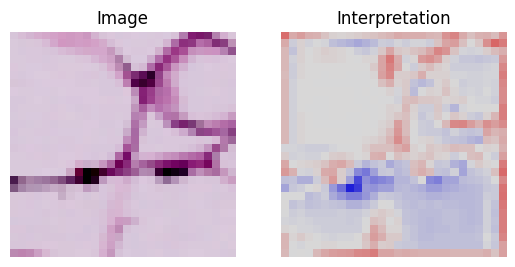

In [ ]:
for l in range(n)[::-1]:
    maps[l] = maps[l].detach().requires_grad_(True)
    if l <= 6:
        incr = lambda z: z + 0.5*((z**2).mean()**.5).detach()
    if l >= 7:
        incr = lambda z: z
    if isinstance(layers[l],torch.nn.Conv2d) or isinstance(layers[l],torch.nn.AvgPool2d):
        z = incr(layers[l].forward(maps[l])) + 1e-9
        s = (rels[l+1]/z).detach()
        (z*s).sum().backward()
        c = maps[l].grad
        rels[l] = maps[l].detach() * c
    else:
        rels[l] = rels[l+1]

im = test_dataset[cur][0]
im = [[[im[0][i][j],im[1][i][j],im[2][i][j]] for j in range(28)] for i in range(28)]

map = np.array(rels[0][0].cpu()).sum(axis=0)
show_interpretation(map, im)

In [ ]:
cur = 0
X = test_dataset[cur][0].reshape(1,3,28,28)
maps = [X]+[None]*n
for l in range(n):
    maps[l+1] = layers[l].forward(maps[l])

scores = np.array(maps[-1].cpu().data.view(-1))
print('SOCRES')
for i in np.argsort(-scores):
    print(str(i)+':', scores[i])
mask = torch.FloatTensor(((np.arange(9)==np.argmax(scores)).reshape([1,9,1,1])))
rels = [None]*n + [(maps[-1]*mask).data]
print('TRUE LABLE')
test_dataset[cur][1].item(),  info['label'][str(test_dataset[cur][1].item())]

SOCRES
8: 0.7618943
5: 0.1770622
6: -0.17681366
7: -1.2112026
2: -1.9430794
4: -2.2961447
3: -3.1232874
0: -4.1303177
1: -4.5835934
TRUE LABLE


(8, 'colorectal adenocarcinoma epithelium')

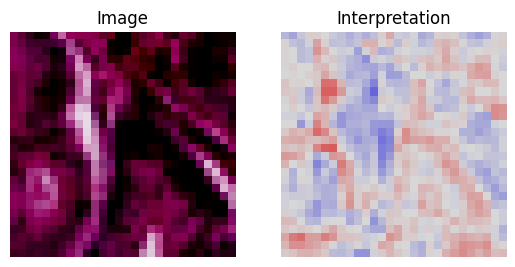

In [ ]:
for l in range(n)[::-1]:
    maps[l] = maps[l].detach().requires_grad_(True)
    if l <= 6:
        incr = lambda z: z + 0.5*((z**2).mean()**.5).detach()
    if l >= 7:
        incr = lambda z: z
    if isinstance(layers[l],torch.nn.Conv2d) or isinstance(layers[l],torch.nn.AvgPool2d):
        z = incr(layers[l].forward(maps[l])) + 1e-9
        s = (rels[l+1]/z).detach()
        (z*s).sum().backward()
        c = maps[l].grad
        rels[l] = maps[l].detach() * c
    else:
        rels[l] = rels[l+1]

im = test_dataset[cur][0]
im = [[[a[0][i][j],a[1][i][j],a[2][i][j]] for j in range(28)] for i in range(28)]

map = np.array(rels[0][0].cpu()).sum(axis=0)
show_interpretation(map, im)

In [ ]:
cur = 8
X = test_dataset[cur][0].reshape(1,3,28,28)
maps = [X]+[None]*n
for l in range(n):
    maps[l+1] = layers[l].forward(maps[l])

scores = np.array(maps[-1].cpu().data.view(-1))
print('SOCRES')
for i in np.argsort(-scores):
    print(str(i)+':', scores[i])
mask = torch.FloatTensor(((np.arange(9)==np.argmax(scores)).reshape([1,9,1,1])))
rels = [None]*n + [(maps[-1]*mask).data]
print('TRUE LABLE')
test_dataset[cur][1].item(),  info['label'][str(test_dataset[cur][1].item())]

SOCRES
6: 0.6926454
5: 0.6790011
8: -0.8587671
7: -1.7855985
4: -2.4004996
0: -2.4200473
2: -2.9199152
3: -3.6026506
1: -3.8773284
TRUE LABLE


(6, 'normal colon mucosa')

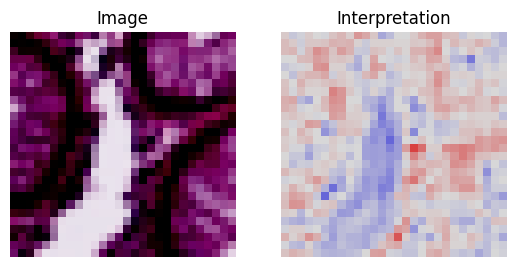

In [ ]:
for l in range(n)[::-1]:
    maps[l] = maps[l].detach().requires_grad_(True)
    if l <= 6:
        incr = lambda z: z + 0.5*((z**2).mean()**.5).detach()
    if l >= 7:
        incr = lambda z: z
    if isinstance(layers[l],torch.nn.Conv2d) or isinstance(layers[l],torch.nn.AvgPool2d):
        z = incr(layers[l].forward(maps[l])) + 1e-9
        s = (rels[l+1]/z).detach()
        (z*s).sum().backward()
        c = maps[l].grad
        rels[l] = maps[l].detach() * c
    else:
        rels[l] = rels[l+1]

im = test_dataset[cur][0]
im = [[[im[0][i][j],im[1][i][j],im[2][i][j]] for j in range(28)] for i in range(28)]

map = np.array(rels[0][0].cpu()).sum(axis=0)
show_interpretation(map, im)

In [ ]:
cur = 14
X = test_dataset[cur][0].reshape(1,3,28,28)
maps = [X]+[None]*n
for l in range(n):
    maps[l+1] = layers[l].forward(maps[l])

scores = np.array(maps[-1].cpu().data.view(-1))
print('SOCRES')
for i in np.argsort(-scores):
    print(str(i)+':', scores[i])
mask = torch.FloatTensor(((np.arange(9)==np.argmax(scores)).reshape([1,9,1,1])))
rels = [None]*n + [(maps[-1]*mask).data]
print('TRUE LABLE')
test_dataset[cur][1].item(),  info['label'][str(test_dataset[cur][1].item())]

SOCRES
0: 2.3004775
5: 1.6716952
4: -1.6629505
8: -2.2095413
6: -2.3080983
7: -2.9204834
1: -3.090943
2: -3.3525643
3: -5.0703783
TRUE LABLE


(0, 'adipose')

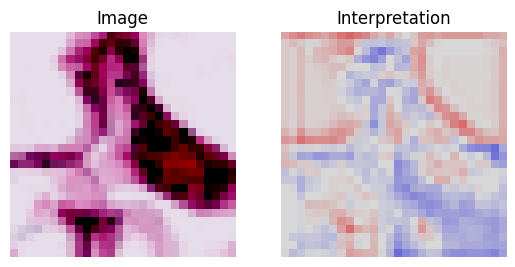

In [ ]:
for l in range(n)[::-1]:
    maps[l] = maps[l].detach().requires_grad_(True)
    if l <= 6:
        incr = lambda z: z + 0.5*((z**2).mean()**.5).detach()
    if l >= 7:
        incr = lambda z: z
    if isinstance(layers[l],torch.nn.Conv2d) or isinstance(layers[l],torch.nn.AvgPool2d):
        z = incr(layers[l].forward(maps[l])) + 1e-9
        s = (rels[l+1]/z).detach()
        (z*s).sum().backward()
        c = maps[l].grad
        rels[l] = maps[l].detach() * c
    else:
        rels[l] = rels[l+1]

im = test_dataset[cur][0]
im = [[[im[0][i][j],im[1][i][j],im[2][i][j]] for j in range(28)] for i in range(28)]

map = np.array(rels[0][0].cpu()).sum(axis=0)
show_interpretation(map, im)

In [ ]:
cur = 15
X = test_dataset[cur][0].reshape(1,3,28,28)
maps = [X]+[None]*n
for l in range(n):
    maps[l+1] = layers[l].forward(maps[l])

scores = np.array(maps[-1].cpu().data.view(-1))
print('SOCRES')
for i in np.argsort(-scores):
    print(str(i)+':', scores[i])
mask = torch.FloatTensor(((np.arange(9)==np.argmax(scores)).reshape([1,9,1,1])))
rels = [None]*n + [(maps[-1]*mask).data]
print('TRUE LABLE')
test_dataset[cur][1].item(),  info['label'][str(test_dataset[cur][1].item())]

SOCRES
5: 3.147124
7: -0.4529683
2: -1.4882317
8: -1.6115634
6: -2.258854
4: -2.733795
0: -3.705163
1: -4.4044695
3: -5.608174
TRUE LABLE


(5, 'smooth muscle')

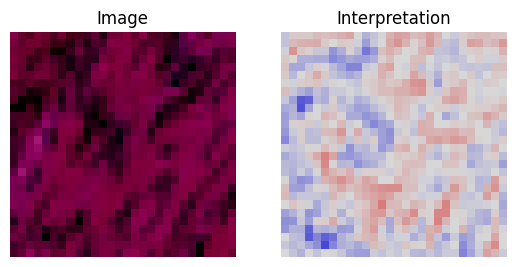

In [ ]:
for l in range(n)[::-1]:
    maps[l] = maps[l].detach().requires_grad_(True)
    if l <= 6:
        incr = lambda z: z + 0.5*((z**2).mean()**.5).detach()
    if l >= 7:
        incr = lambda z: z
    if isinstance(layers[l],torch.nn.Conv2d) or isinstance(layers[l],torch.nn.AvgPool2d):
        z = incr(layers[l].forward(maps[l])) + 1e-9
        s = (rels[l+1]/z).detach()
        (z*s).sum().backward()
        c = maps[l].grad
        rels[l] = maps[l].detach() * c
    else:
        rels[l] = rels[l+1]

im = test_dataset[cur][0]
im = [[[im[0][i][j],im[1][i][j],im[2][i][j]] for j in range(28)] for i in range(28)]

map = np.array(rels[0][0].cpu()).sum(axis=0)
show_interpretation(map, im)

In [ ]:
model = SmallNet(n_channels=n_channels, n_classes=n_classes)#.to(device)
model.load_state_dict(torch.load('model_scripted.pt',map_location=torch.device('cpu')))

<All keys matched successfully>

## FDR control

I arbitrary chose class ‘Adipose’ as positive and used Benjamini-Hochberg protocol (BHP) with empirical p-values (EPV) to construct the dependence between the number of accepted discoveries and False Discovery Rate assuming that true labels are unknown.

In [ ]:
class SmallNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(SmallNet, self).__init__()

        self.layer1 = nn.Sequential(nn.Conv2d(n_channels, 28, kernel_size=3, padding=1),
                                    nn.BatchNorm2d(28), nn.ReLU())
        self.layer2 = nn.Sequential(nn.Conv2d(28, 106, kernel_size=3, padding=1),
                                    nn.BatchNorm2d(106),nn.ReLU())
        self.layer3 = nn.Sequential(nn.Conv2d(106, 60, kernel_size=3, padding=1),
                                    nn.BatchNorm2d(60),nn.ReLU(),
                                    nn.AvgPool2d(kernel_size=14,stride=14))
        self.fc = nn.Sequential(nn.Linear(60 * 4, 177),nn.BatchNorm1d(177),nn.ReLU(),
                                nn.Linear(177, n_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
model = SmallNet(n_channels=n_channels, n_classes=n_classes).to(device)
model.load_state_dict(torch.load('model_scripted.pt'))

<All keys matched successfully>

In [ ]:
def calculate_fdr(model, test_loader):
    model.eval()
    p = 0
    tp = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1).cpu()
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1).cpu()
                targets = targets.float().resize_(len(targets), 1)

            pred = outputs.argmax(axis=1)
            predicted_positive = list(targets[pred == 0])
            p += len(predicted_positive)
            tp += predicted_positive.count(0)
        fdr = 1 - tp / p
        print('Predicted Positive: {}, True Positive: {}, FDR: {}'.format(p, tp, fdr))

In [ ]:
calculate_fdr(model.cpu(), test_loader)

Predicted Positive: 1353, True Positive: 1323, FDR: 0.022172949002217335


In [ ]:
# False Discovery Rate: 2.2%

In [ ]:
from bisect import bisect
def calculate_fdr(scores, labels):
    sort_data = torch.sort(scores, descending=True)
    sorted_test_labels = labels[sort_data[1].data.cpu().numpy()]

    negative = 0
    positive = 0
    fdr = []
    for label in sorted_test_labels:
        negative += label.item() == 0
        positive += label.item() == 1
        fdr.append(negative / (negative + positive))
    return np.array(fdr)


def calculate_qvalues_from_labels(scores, labels):
    qvalue = calculate_fdr(scores, labels)
    for i in range(len(qvalue) - 1, 0, -1):
        qvalue[i - 1] = min(qvalue[i], qvalue[i - 1])
    return qvalue

def empirical_p_values(distribution, query):  # distribution - sorted list, query - list
    dist_len = len(distribution)
    query_len = len(query)
    p_values = np.zeros([query_len, ])

    for i, score in enumerate(query):
        p_values[i] = (dist_len - bisect(distribution, score)) / dist_len
    return np.sort(p_values)

def calculate_qvalues_from_pvalues(distribution, query, pi_0=0.9):
    p_values = empirical_p_values(np.sort(distribution), query)
    q_values = p_values * len(p_values) * pi_0
    q_values = q_values / np.arange(1, len(p_values) + 1)
    for i in range(len(p_values) - 1, 0, -1):
        q_values[i - 1] = min(q_values[i - 1], q_values[i])

    return q_values

In [ ]:
scores = torch.tensor([])
labels = torch.tensor([])
for data in tqdm(test_loader):
    res = model(data[0].to(device)).cpu()
    scores = torch.cat((scores,res[:,0]))
    labels = torch.cat((labels,data[1] == 0))

  0%|          | 0/29 [00:00<?, ?it/s]

In [ ]:
from numpy import savetxt
savetxt('scores.csv', scores.detach(), delimiter=',')
savetxt('labels.csv', labels.detach(), delimiter=',')

In [ ]:
import pandas as pd
scores = torch.tensor(np.array(pd.read_csv('/content/scores.csv', sep=',', header=None))[:,0])
labels = torch.tensor(np.array(pd.read_csv('/content/labels.csv', sep=',', header=None))[:,0])

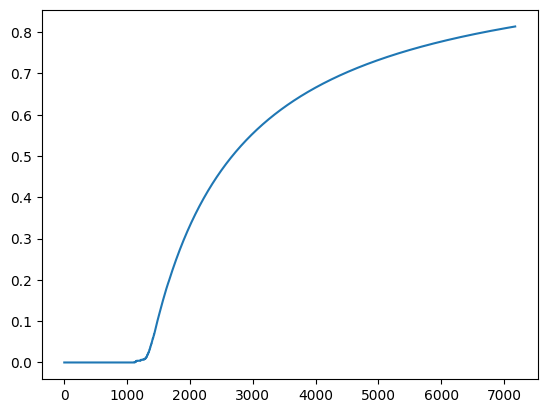

In [ ]:
fdr = calculate_fdr(scores, labels)
qvalues = calculate_qvalues_from_labels(scores, labels)
plt.plot(qvalues)

In [ ]:
train_scores_n = torch.tensor([])
train_scores_p = torch.tensor([])
with torch.no_grad():
    i = 1
    for data in tqdm(train_loader):
        i += 1
        res = model(data[0].to(device)).cpu()
        train_scores_n = torch.cat((train_scores_n,res[:,0][data[1][:,0] != 0]))
        train_scores_p = torch.cat((train_scores_p,res[:,0][data[1][:,0] == 0]))
        if i == 20:
            torch.cuda.empty_cache()
            gc.collect()

  0%|          | 0/709 [00:00<?, ?it/s]

In [ ]:
savetxt('train_scores_n.csv', train_scores_n.detach(), delimiter=',')
savetxt('train_scores_p.csv', train_scores_p.detach(), delimiter=',')

In [ ]:
train_scores_n = torch.tensor(np.array(pd.read_csv('/content/train_scores_n.csv', sep=',', header=None))[:,0])
train_scores_p = torch.tensor(np.array(pd.read_csv('/content/train_scores_p.csv', sep=',', header=None))[:,0])

In [ ]:
counter_test = [0]*9
for data in tqdm(test_loader):
    ls = model(data[0].to(device)).argmax(axis=1)
    for i in ls:
        counter_test[i]+=1
counter_test

  0%|          | 0/29 [00:00<?, ?it/s]

[1322, 910, 479, 652, 949, 588, 697, 375, 1208]

In [ ]:
#Consider class 0 to be positive
pi_0 = 1 - 1322 / 7180
pi_0

0.8158774373259052

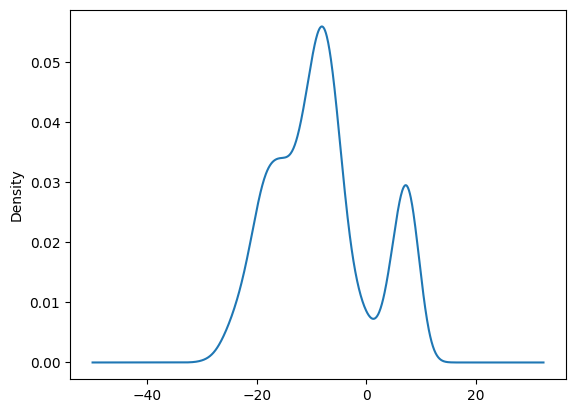

In [ ]:
prob = pd.Series(scores.detach()).plot.kde().get_lines()[0].get_xydata()[500:700]

In [ ]:
mid = min(prob, key=lambda x: x[1])
prob[0], mid, prob[-1]

(array([-8.77898425,  0.05513036]),
 array([1.28882063, 0.00726804]),
 array([7.64309093, 0.02907127]))

In [ ]:
scores_n = scores[scores <= mid[0]]
scores_p = scores[scores > mid[0]]

In [ ]:
m_n_tr = train_scores_n.mean()
std_n_tr = train_scores_n.std()
m_n = scores_n.mean()
std_n = scores_n.std()
m_n_tr.item(), std_n_tr.item(), m_n.item(), std_n.item()

(-10.204375267028809, 6.088318347930908, -11.65488052368164, 6.010615825653076)

In [ ]:
m_p_tr = train_scores_p.mean()
m_p = scores_p.mean()
m_p_tr.item(), m_p.item()

(8.245513916015625, 6.832746505737305)

In [ ]:
scores_n = (scores_n - m_n) / std_n * std_n_tr + m_n_tr
scores_p = scores_p - m_p + m_p_tr
scores = torch.cat((scores_n, scores_p))

In [ ]:
eqv = calculate_qvalues_from_pvalues(train_scores_n, scores, pi_0)

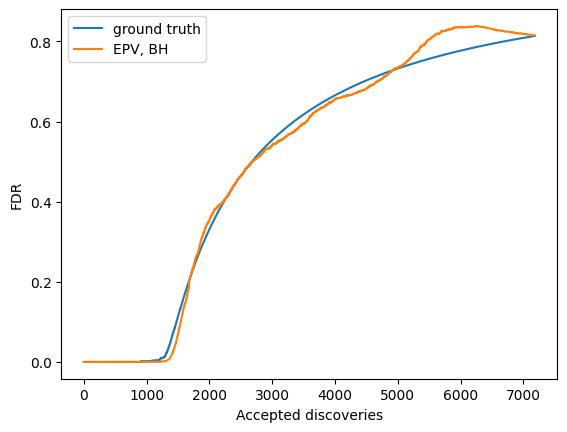

In [ ]:
plt.plot(qvalues, label='ground truth')
plt.plot(eqv, label='EPV, BH')
plt.xlabel("Accepted discoveries")
plt.ylabel("FDR")
plt.legend()

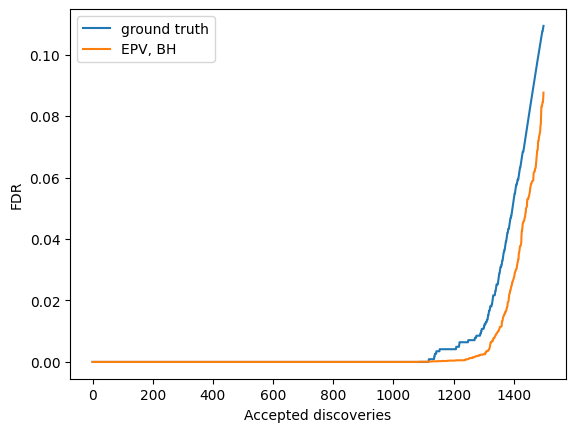

In [ ]:
plt.plot(qvalues[:1500], label='ground truth')
plt.plot(eqv[:1500], label='EPV, BH')
plt.xlabel("Accepted discoveries")
plt.ylabel("FDR")
plt.legend()

## End